# 30-49 årige erhvervsfrekvens - delmodel

### 1) Modellen

\begin{align*}
E_t &= E_t^* + E_t^c \\[1em]
E_t^* &= E_{t-1}^* + \mu_1 \Delta leave3049_t + \varepsilon_t^*, \quad \varepsilon_t^* \sim N(0, \sigma_{\varepsilon^*}^2) \\[1em]
E_t^c &= \psi_1 E_{t-1}^c + \psi_2 E_{t-2}^c + \theta u^c_{t-1} + \varepsilon_t^c, \quad \varepsilon_t^c \sim N(0, \sigma_{\varepsilon^c}^2) \\[1em]
shortage_{t} &= \eta_0 + \eta_1 E_t^c + \varepsilon_t^{shortage}, \quad \varepsilon_t^{shortage} \sim N(0, \sigma_{shortage}^2)
\end{align*}

### 2) Vektorspecifikation
$$
y_t =
\begin{bmatrix}
E_t \\
shortage_{t}
\end{bmatrix}
\quad
x_t =
\begin{bmatrix}
E^*_t \\
E^c_{t} \\
E^c_{t-1}
\end{bmatrix}
\quad 
z_t = \begin{bmatrix}
    \Delta leave3049_t \\
    u^c_{t-1}
\end{bmatrix}
$$

### 3) Relationer

De observerede variable er

$$
y_t = 
\underbrace{\begin{bmatrix}
1 & 1 & 0 \\  
0 & \eta_1 & 0 
\end{bmatrix}}_{C} 
x_t + \underbrace{\begin{bmatrix}
    0 \\
    \eta_0
\end{bmatrix}}_{d} + \begin{bmatrix}
0 \\
\varepsilon_t^{shortage}
\end{bmatrix}.
$$

Ligningerne for udviklingen i state space variablene kan skrives som

$$
x_t = 
\underbrace{\begin{bmatrix}
    1 & 0 & 0  \\
    0 & \psi_1 & \psi_2 \\
    0 & 1 & 0 
\end{bmatrix}}_{A} x_{t-1}
+ 
\underbrace{\begin{bmatrix}
    \mu_1 & 0 \\
    0 & \theta \\
    0 & 0
\end{bmatrix}}_{B}
z_t
+
\begin{bmatrix}
    \varepsilon_t^* \\
    \varepsilon_t^c \\
    0
\end{bmatrix}.
$$

Den resulterende kovarians-matrix for state space er derfor 

$$Q=
\begin{bmatrix}
\sigma_{\varepsilon^*}^2 & 0 & 0 \\
0 & \sigma_{\varepsilon^c}^2 & 0 \\
0 & 0 & 0 \\
\end{bmatrix}
$$

Og for de observerede variable

$$R=
\begin{bmatrix}
0 & 0 \\
0 & \sigma_{shortage}^2 \\
\end{bmatrix}$$

## Dette script gør følgende:

0) Henter julia-pakker
1) Sætter indstillinger 
2) Definerer parametre til estimation af strukturel erhvevsfrekvens jf. ovenstående samt sætter initialt gæt til igangsættelsen af algoritmen
3) Definerer funktioner filter+smoother der returnerer den estimerede erhvervsfrekvens for 30-49 årige
4) Indlæser input data
5) Estimerer strukturel erhvervsfrekvens
6) Plotter resultatet og gemmer resultatet i excel-format 

## 0) Henter pakker

In [1]:
using Random, Distributions, LinearAlgebra, Plots, XLSX, DataFrames, Optim

## 1) Sæt indstillinger

### I dette afsnit findes indstillingerne for hentning af data, filtrering af serien og lagring af det resulterende output.


In [9]:
# Opdater PRBANK for dataindtastning
PRBANK = "2409"

# Sæt periode(r)
Filtration_period = ["1984q2","2028q4"] # Dette er hele interesseperioden, inklusive prognoseperioden
Estimation_period = ["1984q2","2024q3"] # Dette er den observerede periode (uden prognoseperioden) OBS: I denne periode antages der at der ikke er manglende observationer

# Angiv variable-navne i inputdata
Erhvervsfrekvens = [:ERHFRK2_3049] # Navnet på kolonnen for erhvervsfrekvens (første element i Y)
Shortage = [:ARBBEK] # Navnet på kolonnen for mangel (andet element i Y)
Leave3049 = [:DORLOVMVFRK3049] # Navnet på kolonnen for Δleave3049 (første element i Z)
U_lagged = [:bulgrad_gab] # Navnet på kolonnen for forsinket arbejdsløshedsgab (andet element i Z)

# Angiv om der er manglende observationer i prognoseperioden
missing_obs = true # Sættes til false, hvis der er observationer for hele perioden (inklusiv prognoseår)

# Angiv om den strukturelle erhvervsfrekvens skal smoothed 
smoothing = true # Sættes til false, hvis der KUN ønskes at køre kalman-filteret men ikke smootheren

lags = 0


0

## 2) Definer parametre og matrixdekomposition

#### Dette er baseret på den ovenstående statespace-repræsentation. Nuværende parameterværdier er indtastet fra ox-log filer, så tidligere resultater replikeres.

In [3]:
θ_0 = [
    0.82293, # ψ1
    0.06414, # ψ2
    -0.44027, # μ1
    -3.22096, # θ
    0.00552, # η1
    0.02436, # η0
    0.08239, # σ_star 
    0.34957, # σ_c
    0.02609  # σ_short
]

x0 = [89.54467,-0.79178,0.0]
P0 = Matrix{Float64}(I, 3, 3)*1.33223^2  


3×3 Matrix{Float64}:
 1.77484  0.0      0.0
 0.0      1.77484  0.0
 0.0      0.0      1.77484

In [4]:
function construct_Matrices(θ)
    A = [
        1.0  0.0  0.0;     #θ[1]=ψ_1 θ[2]=ψ_2 θ[3]=μ_1 θ[4]=θ θ[5]=η_1 θ[6]=η_0 θ[7]=σ_* θ[8]=σ_c θ[9]=σ_shortage
        0.0  θ[1]   θ[2];      
        0.0  1.0  0.0      
        ]
    
    B = [
        θ[3]   0.0; 
        0.0  θ[4];
        0.0  0.0
        ]
    
    C = [
        1.0   1.0   0.0;   
        0.0   θ[5]    0.0    
        ]
    
    d = [0.0, θ[6]] 
        
    Q = Diagonal([θ[7]^2, θ[8]^2, 0.0])
    R = Diagonal([0.0, θ[9]^2])

    return A, B, C, d, Q, R
end

construct_Matrices (generic function with 1 method)

In [5]:
A, B, C, d, Q, R = construct_Matrices(θ_0)

([1.0 0.0 0.0; 0.0 0.82293 0.06414; 0.0 1.0 0.0], [-0.44027 0.0; 0.0 -3.22096; 0.0 0.0], [1.0 1.0 0.0; 0.0 0.00552 0.0], [0.0, 0.02436], [0.006788112100000001 0.0 0.0; 0.0 0.1221991849 0.0; 0.0 0.0 0.0], [0.0 0.0; 0.0 0.0006806881])

## 3) Kalman-filter

### The Kalman filter algorithm
The Kalman filter consists of two steps:

1. *Prediction Step*.<br>
    
    \begin{align}
        x_{t|t-1} &= Ax_{t-1|t-1} + Bz_t \tag{State prediction} \\
        P_{t|t-1} &= AP_{t-1|t-1}A' + Q \tag{Prediction error covariance matrix}
    \end{align}
    $$

- where $Q$ is the covariance matrix for the state vector. 

2. *Update Step*.<br>
     
   $$
   \begin{align}
        K_t &= P_{t|t-1}C'(CP_{t|t-1}C' + R)^{-1} \tag{Kalman gain matrix} \\
        x_{t|t} &= x_{t|t-1} + K_t(y_t - Cx_{t|t-1}-d) \tag{State update} \\
        P_{t|t} &= (I - K_tC)P_{t|t-1} \tag{Covariance matrix update}
   \end{align}
   $$
   
Explanation:
- $x_{t|t-1}$ is our *predicted* state at time $t$ given information at time $t-1$.
- $x_{t|t}$ is our updated state estimate given information at time $t$ $\vert \vert$ often called the filtered estimate 
- $P_{t|t-1}$ is the predicted estimation error covariance matrix
- $P_{t|t}$ is the updated (filtered) estimation error covariance matrix
- $K_t$ is the so-called Kalman gain
- $I$ is the identity matrix


 OBS: til nedenstående funktion er tilføjet t_missing der angiver at der kan være observationer, hvor elementer i Y ikke er observeret. Hvis dette er tilfældet bruger man ikke denne del af Y til at opdatere sine prediktioner for state space variablene. I praksis sætter man residualet mellem det observerede og prædekterede værdier til 0 for dette element i Y. Bemærk man fortsat bruger første element i Y til at opdatere state space variable. Hvis t_missing ikke er angivet antages at der ikke er nogle manglende observationer.

In [6]:
function kalman_filter(A, B, C, d, Q, R, Y, Z, x0, P0,t_missing=Inf)

    # Declare placeholders 
    T = size(Y, 2)
    nx = size(A, 1)
    ny = size(C, 1)
    xhat = zeros(nx, T) 
    Phat = Vector{Matrix{Float64}}(undef, T) 
    predicted_x = zeros(nx, T) 
    predicted_P = Vector{Matrix{Float64}}(undef, T)
    y_tilde = zeros(ny,T) 

    # Initialize
    xhat_pred = x0
    xhat[:,1] = xhat_pred
    predicted_x[:,1] = xhat_pred
    P_pred = P0
    Phat[1] = P_pred
    predicted_P[1] = P_pred

    # Declare identity matrix
    I_M = Matrix{Float64}(I, nx, nx)  # Identity matrix of size nx

    for t in 2:T
        if t < t_missing
            # 1) Predict
            xhat_pred = A * xhat_pred + B * Z[:, t]
            P_pred    = A * P_pred * A' + Q
            predicted_x[:,t] = xhat_pred # Store predictions
            predicted_P[t] = P_pred # Store predictions

            # 2) Update
            # Innovation (measurement residual)
            ytilde = Y[:, t] - (C * xhat_pred .+ d)
        
            # Innovation covariance
            S = C * P_pred * C' + R
            # Kalman gain
            K = P_pred * C' * inv(S)

            # Posterior (updated) state
            xhat[:, t] = xhat_pred + K * ytilde

            # Posterior covariance
            Phat[t] = (I_M .- K * C) * P_pred
        
            # 3) Prepare for next iteration
            xhat_pred = xhat[:, t]
            P_pred    = Phat[t]
        else
            xhat_pred = A * xhat_pred + B * Z[:, t]
            P_pred    = A * P_pred * A' + Q
            predicted_x[:,t] = xhat_pred # Store predictions
            predicted_P[t] = P_pred # Store predictions
            y_tilde[1,t] = Y[1,t] - dot(C[1,:],xhat_pred)
            y_tilde[2,t] = 0.0
            
            S = C * P_pred * C' + R
            K = P_pred * C' * inv(S)
            xhat[:,t] = xhat_pred + K * y_tilde[:,t]
            Phat[t] = (I_M .- K * C) * P_pred
            xhat_pred = xhat[:, t]
            P_pred    = Phat[t]
        end
    end

    return xhat, Phat, predicted_x, predicted_P
end



kalman_filter (generic function with 2 methods)

## Kalman-Smoother

### Defining the kalman smoother

**The Algorithm Step by Step**:

1. *Initialization*: Start with the final filtered estimates $x_{T|T}$ and $P_{T|T}$. These come from the last step of the Kalman filter. 

2. *Backward Recursion* (for $t = T-1, T-2, \dots, 1$):<br>
   a)
   First, compute the smoother gain:
   $$ J_t = P_{t|t}A'(P_{t+1|t})^{-1} $$
    
    b) Update the state estimate:
    $$ x_{t|T} = x_{t|t} + J_t(x_{t+1|T} - Ax_{t|t}-Bz_t) $$

    c) Update the uncertainty:
    $$ P_{t|T} = P_{t|t} + J_t(P_{t+1|T} - P_{t+1|t})J_t' $$


In [7]:
function Kalman_smoother(x_pred::AbstractArray, P_pred::AbstractArray, 
    x_filt::AbstractArray, P_filt::AbstractArray, 
    A::AbstractArray)

    n = size(x_filt, 2)
    number_of_state_variables = size(x_filt, 1)

    x_smooth = zeros(number_of_state_variables, n)
    P_smooth = zeros(number_of_state_variables, number_of_state_variables, n)

    x_smooth[:, n] = x_filt[:, n]
    P_smooth[:,:,n] = P_filt[n]

    for t in (n-1):-1:1
        J = P_filt[t] * A' * inv(P_pred[t+1]) 
        
        x_smooth[:,t] = x_filt[:,t] + J * (x_smooth[:,t+1] - x_pred[:,t+1])
        P_smooth[:,:,t] = P_filt[t] + J * (P_smooth[:,:,t+1] - P_pred[t+1]) * J'
    end

    return x_smooth, P_smooth
end

Kalman_smoother (generic function with 1 method)

## 4) Hent data

In [10]:
# Hent data
file_path = "G:\\Konjunktur\\Produktionsgab\\Gekko\\Data\\Input\\gabinput_pr$PRBANK.xlsx"
sheet_name = "Data"
wb = XLSX.readxlsx(file_path)
ws = wb[sheet_name]
raw_data = XLSX.getdata(ws)

# Omdan til en dataframe
df = DataFrame(raw_data,:auto)
df[1, :x1] = "PERIOD"
header = [string(df[1, col]) for col in names(df)]
df = df[2:end, :]
mapping = Dict(zip(names(df), Symbol.(header)))
rename!(df, mapping)

# Begræns periode og angiv hvilke variabler der skal vælges
firstdatapoint_filt = findfirst(==( Filtration_period[1]), df[!, :PERIOD]) - lags
lastdatapoint_filt = findfirst(==( Filtration_period[2]), df[!, :PERIOD])
df = df[firstdatapoint_filt:lastdatapoint_filt,:]

#df = filter(row -> row.PERIOD >= Filtration_period[1] && row.PERIOD <= Filtration_period[2], df)
df_estimation = filter(row -> row.PERIOD >= Estimation_period[1] && row.PERIOD <= Estimation_period[2], df) # Denne dataframe har kun historisk data så der antages ingen manglende observationer

E = Array{Float64}(df[:,Erhvervsfrekvens])
shortage = Array{Float64}(df[:,Shortage])
leave3049 = Array{Float64}(df[:,Leave3049])

# Hent forsinket arbejdsløshedsgab (Dette bør ikke være nødvendigt i den endelige version, da alle inputdata skal være tilgængelige i inputarket) SLET NÅR DET IKKE LÆNGERE ER NØDVENDIGT
file_path_gab = "G:\\Konjunktur\\Produktionsgab\\Gekko\\Resultater\\Struk_led\\Excel\\ulb_pr$(PRBANK)_f.xlsx" 
sheet_name_gab = 1  
wb_gab = XLSX.readxlsx(file_path_gab)
ws_gab = wb_gab[sheet_name_gab]
raw_data_gab = XLSX.getdata(ws_gab)
df_gab = DataFrame(raw_data_gab,:auto)
df_gab[1, :x1] = "PERIOD"
header_gab = [string(df_gab[1, col]) for col in names(df_gab)]
df_gab = df_gab[2:end, :]
mapping_gab = Dict(zip(names(df_gab), Symbol.(header_gab)))
rename!(df_gab, mapping_gab)
df_gab_retrieve = df_gab[nrow(df_gab) - nrow(df):end-1,:]
u_lagged = Array{Float64}(df_gab_retrieve[:,U_lagged])

# Konstruer datamatricer
T = nrow(df)
elements_in_y = 2
elements_in_z = 2
Y = zeros(elements_in_y, T)
Z = zeros(elements_in_z, T)

for t in 1:T
    Y[:, t] = [E[t]; shortage[t]]
    Z[:, t] = [leave3049[t]; u_lagged[t]]
end

print("\nDimensioner af Y: $(size(Y))")
print("\nDimensioner af Z: $(size(Z))")



Dimensioner af Y: (2, 179)
Dimensioner af Z: (2, 179)

In [11]:
# Hent tidligere estimeret gab til sammenligning (Kan slettes)
file_path_compare = "G:\\Konjunktur\\Produktionsgab\\Gekko\\Resultater\\Struk_erh\\Excel\\pr2409_e3049_f.xlsx" 
sheet_name_compare = "1"  
table_data_compare = XLSX.readtable(file_path_compare, sheet_name_compare)
df_compare = DataFrame(table_data_compare)
for col in names(df_compare)
    replace!(df_compare[!, col], "#N/A" => missing)
end
df_compare = dropmissing(df_compare)
compare_E = Array{Float64}(df_compare.Erhfrk_str)
compare_E = compare_E[1:178]

178-element Vector{Float64}:
 90.06209486075346
 90.03205251283347
 90.00025062051775
 89.99203222060149
 89.97581497868026
 89.95817548610071
 89.93232946187287
 89.93063750387374
 89.91162420202639
 89.87671626298406
  ⋮
 85.05617813633941
 85.11359607088527
 85.16799963714948
 85.21617397534524
 85.26062363633973
 85.30309383136789
 85.34154239233197
 85.38248014441088
 85.41942839308987

## 5) Kør Kalman smoother og plot resultatet

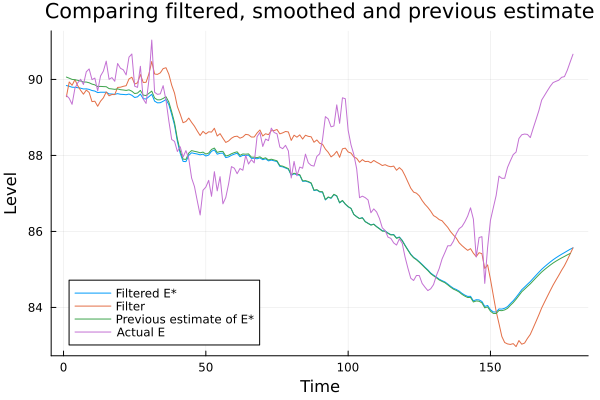

In [12]:
# Sæt t_missing til tidspunkt, hvor al data er tilgængelig
t_missing = nrow(df_estimation) + 1 

if missing_obs
    xhat, Phat,predict_x,predict_p = kalman_filter(A, B, C, d, Q, R, Y, Z, x0, P0,t_missing)
    x_smoothed, P_smoothed = Kalman_smoother(predict_x, predict_p, xhat, Phat, A)
else
    xhat, Phat,predict_x,predict_p = kalman_filter(A, B, C, d, Q, R, Y, Z, x0, P0)
    x_smoothed, P_smoothed = Kalman_smoother(predict_x, predict_p, xhat, Phat, A)
end

plot(
    1:T, x_smoothed[1, :], label="Filtered E*",
    title="Comparing filtered, smoothed and previous estimate",
    xlabel="Time", ylabel="Level"
)
plot!(1:T, xhat[1, :], label="Filter")
plot!(1:T-1, compare_E[1:178],label="Previous estimate of E*")
plot!(1:T, Y[1, :], label="Actual E")

## 6) Gem resultater

### Den estimerede strukturelle erhvervsfrekvens samt gab gemmes i excel-format 

In [ ]:
# Få periodevektor og omdan til ønsket format på form yyyy(q)
df_per = df
df_per[!, :PERIOD] = replace.(df_per.PERIOD, r"q(\d)" => s"(\1)")

# Klargør samlet output-matrix
Output = zeros(size(Y,2),4)
Output = Matrix{Any}(undef, size(Y,2), 4)  
Output[:,1] = df_per[!,"PERIOD"] # Første søjle i output er periode-vektor
Output[:,2] = Y[1,:]' # Anden søjle i output er faktisk erhvervsfrekvens

# Hvis smoothing=true sæt tredje søjle i output til strukturel(smoothed) erhvervsfrekvens. Kun filter, hvis smoothing=false.
if smoothing
    Output[:,3] = x_smoothed[1,:]'
else
    Output[:,3] = xhat[1,:]'
end

Output[:,4] = Output[:,2] .- Output[:,3] # 4. søjle i output er gabet der defineres som forskellen mellem faktisk og strukturel erhvervsfrekvens

# Gem i excel-format
obs_for_excel = size(Output,1) + 1
output_file_path = "G:\\dansk\\tjb\\MBES\\Produktionsgab\\gab_output3049_erhv_$(PRBANK).xlsx"
XLSX.openxlsx(output_file_path, mode="w") do xf
    sheet = xf[1]
    sheet["A1"] = ""
    sheet["B1"] = "Faktisk erhvervsfrekvens"
    sheet["C1"] = "Strukturel"
    sheet["D1"] = "gab"
    sheet["A2:D$(obs_for_excel)"] = Output
end


print("Output has been saved and stored at $output_file_path")